In [1]:
import numpy as np
from numpy import Inf
import sys
import pyEXP
##  exp
sys.path.append("/u/svarel/exp/build/utils/Analysis/")
from spherical_basis_builder import *
#import simpleSL

## Auriga
import LibAu as la

In [2]:
nhalo=21 #Name Halo
nsnap= 63 #z=0
sim = la.Reader_Au(Nhalo=nhalo,Nsnap=nsnap) #Read Simulation
header = sim.Header()
h=header['hubbleparam']
sc=header['time']

Rvir =sim.sf.data['frc2'][0]*1000*sc/h
Mvir =sim.sf.data['fmc2'][0]*1e10/h
Npart = sim.sf.data['slty'][0]
print(Mvir,Rvir,Npart)

fields_stars = ['pos','vel','id','mass','type','pot','age']
Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)


fields_dm = ['pos','vel','id','mass','type','pot']
DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
#Rotate Halo
Data = {'stars':Datstars,'dm1':DatDM}
param = {'spos':sim.sf.data['spos'][0,:],'svel':sim.sf.data['svel'][0,:],'header':sim.Header()}
gal = la.ToolRot(Data=Data, param=param)
Data = gal.Rotate()

Datstars=Data['stars']
DatDM = Data['dm1']

potdm = DatDM['pot']

2088654433553.4023 349.25210558595916 [11792260 31503466        0        0 19107866        1]


/u/svarel/.local/lib/python3.6/site-packages/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


In [3]:
print('IDhalo: Au-%s'%nhalo)
print('Nsnap: %s'%nsnap)
print('R200: %.3f kpc'%Rvir)
print('M200: %.3f Msun'%np.log10(Mvir))
print('Ngas: %e '%Npart[0])
print('Ndm: %e '%Npart[1])
print('Nstar: %e '%Npart[4])
print('Ntot: %e '%(np.sum(Npart)-1))


IDhalo: Au-21
Nsnap: 63
R200: 349.252 kpc
M200: 12.320 Msun
Ngas: 1.179226e+07 
Ndm: 3.150347e+07 
Nstar: 1.910787e+07 
Ntot: 6.240359e+07 


In [4]:
pos = DatDM['pos'] #part_rot[not_in_subs]
mass = DatDM['mass']  #part['dark']['mass'][not_in_subs]
print(np.sum(mass), mass[0], len(pos), len(mass))
M_tot = np.sum(mass)

#selecting 1million random particles
ind = np.arange(0,len(mass),1,dtype=int)
sel = np.random.choice(ind, 1000000, replace=False).astype(int)
pos,mass = pos[sel],mass[sel]
potdm=potdm[sel]

Mfac = M_tot/np.sum(mass)
mass = mass*Mfac

rr = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
rrmax=np.nanmax(np.log10(rr))
r,rho = return_density(np.log10(rr), 1., rangevals=[0., rrmax],bins=100)



1909857200000.0 60622.2 31503466 31503466


In [15]:
#r, rho = halo_st.density_profile(nbins=100, rmin=0, rmax=600)
R,D,M,P = makemodel_empirical(r, rho, "Au{}_table.txt".format(nhalo))

! Scaling:  R= 718.465906283575   M= 1.0   M0= 997807.2634442615   R0= 718.465906283575
1.0 1.0021975552153925e-06 1.0021975552153925e-06 1.0021975552153925e-06


Text(0.5, 0, 'R')

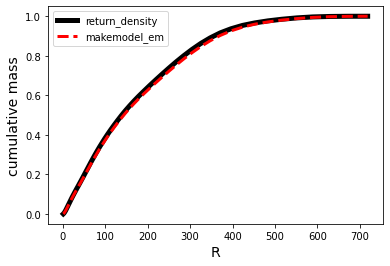

In [16]:
#pos,mass
#Ordeno datos de Auriga
rbord = np.argsort(rr)
rb,mb,pwau = rr[rbord],mass[rbord],potdm[rbord]
ran = (rb<=r[-1])
rb,mb,pwau = rb[ran],mb[ran],pwau[ran] #Datos directamente de Auriga
mbacc = np.cumsum(mb)
#########################################################
#datos de return_density
dm = (4/3)*np.pi*D*R**3
#dm2 = 2*np.pi*(rbins**2)*dreturn*(rbins[1]-rbins[0])
Macc = np.cumsum(dm)


rmax = np.nanmax(r)
plt.subplot(111)
plt.plot(r,Macc/Macc[-1],color='k',label='return_density',lw=5)
#plt.plot(rb,mbacc/mbacc[-1],color='c',label='Auriga',lw=3,ls='-')
plt.plot(R, M,c='r',ls='--', label='makemodel_em',lw=3)
plt.legend()
plt.ylabel('cumulative mass',fontsize=14)
plt.xlabel('R',fontsize=14)

4.5433154170959243e-39


Text(0.5, 0, 'R')

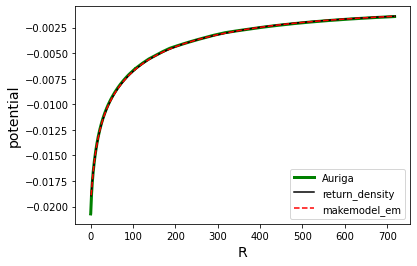

In [17]:
G= 6.674*1e-11 #m3⋅kg−1⋅s−2
m2kpc, kg2Msun = 3.2408*1e-20,5e-31
G=G*(m2kpc**3) /kg2Msun # kpc3 Msun-1 s-2
print(G)
#pvals = -mvals/(rvals+1.e-10) - (pwvals[dvals.size-1] - pwvals)

pwau_ = pwau*(3.24078e-17)**2 /G# (1/(G*mbacc[-1]) )
pwauacc = ((-mbacc/rb) - (np.sum(pwau_)-np.cumsum(pwau_)))#  *(rb[-1]/mbacc[-1])
Potau = ((-mbacc/rb) - (np.sum(mb/rb)-np.cumsum(mb/rb))) *(1/mbacc[-1]) # <----------

Pw = dm/r
Pwacc = ((-Macc/r) - (np.sum(Pw)-np.cumsum(Pw)))  *(1/Macc[-1])
plt.subplot(111)

plt.plot(rb,Potau,color='g',label='Auriga',lw=3)
plt.plot(r,Pwacc,color='k',label='return_density')
plt.plot(R, P,c='r',ls='--', label='makemodel_em')
plt.legend()
plt.ylabel('potential',fontsize=14)
plt.xlabel('R',fontsize=14)

In [28]:
config="""
---
id: sphereSL
parameters :
  numr: %s
  rmin: %s
  rmax: %s
  Lmax: 4
  nmax: 10
  modelname: %s_table.txt
...
"""%(100,np.min(R), np.max(R),'Au'+str(nhalo))
config

'\n---\nid: sphereSL\nparameters :\n  numr: 100\n  rmin: 1.0336030919642736\n  rmax: 718.465906283575\n  Lmax: 4\n  nmax: 10\n  modelname: Au21_table.txt\n...\n'

In [29]:
basis = pyEXP.basis.Basis.factory(config)


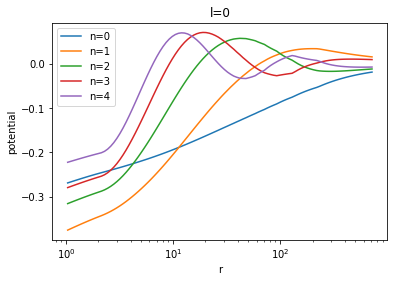

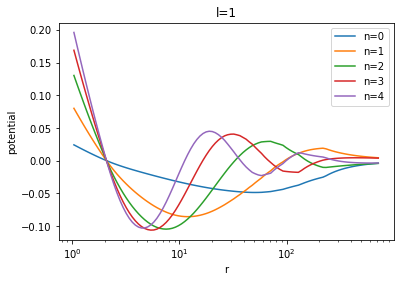

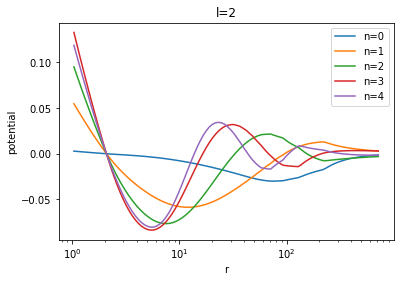

In [37]:

# Construct the basis instances
#
basis = pyEXP.basis.Basis.factory(config)

# Prints info from Cache
#basis.cacheInfo('.slgrid_sph_cache')


lrmin = np.log10(np.min(R))
lrmax = np.log10(np.max(R))
rnum  = 100 
basis_grid = basis.getBasis(lrmin, lrmax, rnum)


r = np.linspace(lrmin, lrmax, rnum)
r = np.power(10.0, r)


for l in range(3):
    for n in range(5):
        plt.semilogx(r, basis_grid[l][n], '-', label="n={}".format(n))
    plt.xlabel('r')
    plt.ylabel('potential')
    plt.title('l={}'.format(l))
    plt.legend()
    #plt.savefig('/mnt/home/nico/projects/cosmo_wakes/pyEXP_ex/m12i_test_empirical_basis_{}.png'.format(l), bbox_inches='tight
    plt.show()


In [34]:
batches = pyEXP.read.ParticleReader.parseFileList('file.list', '')

In [35]:
batches

[]